# Objective:

How can predictive modeling do with predicting players that will get a hit in a baseball game? First, in order to predict a hit, what variables can a model be trained on?

# Outline:

- STEP 1: Load and prepare the data
- STEP 2: Explore and visualize

In [42]:
# Imports
import pandas as pd
import seaborn as sns # plotting
from statsmodels.graphics.gofplots import qqplot
import itertools
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing 

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, RandomForestClassifier

from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, classification_report, roc_auc_score, roc_curve, auc

In [101]:
def plot_feature_importances(model):
    '''
    Visualization for future importance
    '''
    n_features = X_train.shape[1]
    plt.figure(figsize=(6,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

In [94]:
# Function to visualize confusion matrix

def show_cf(y_true, y_pred, class_names=None, model_name=None):
    cf = confusion_matrix(y_true, y_pred)
    plt.imshow(cf, cmap=plt.cm.Blues)
    
    if model_name:
        plt.title("Confusion Matrix: {}".format(model_name))
    else:
        plt.title("Confusion Matrix")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    class_names = set(y_true)
    tick_marks = np.arange(len(class_names))
    if class_names:
        plt.xticks(tick_marks, class_names)
        plt.yticks(tick_marks, class_names)
    
    thresh = cf.max() / 2.
    
    for i, j in itertools.product(range(cf.shape[0]), range(cf.shape[1])):
        plt.text(j, i, cf[i, j], horizontalalignment='center', color='white' if cf[i, j] > thresh else 'black')

    plt.colorbar()

# Step 1: Load and Prepare

What data can be downloaded each day to predict a hit? Baseball Savant's batted ball data from 2018 will give me 40,000 individual events. Let's explore and visualize what we have.

In [116]:
# Load data
df = pd.read_csv('savant_dataTRAIN.csv')

In [6]:
# How much do we have?
df.shape

(40000, 89)

In [7]:
# What are the features?
df.columns

Index(['pitch_type', 'game_date', 'release_speed', 'release_pos_x',
       'release_pos_z', 'player_name', 'batter', 'pitcher', 'events',
       'description', 'spin_dir', 'spin_rate_deprecated',
       'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des',
       'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type',
       'hit_location', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x',
       'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b',
       'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y',
       'tfs_deprecated', 'tfs_zulu_deprecated', 'fielder_2', 'umpire', 'sv_id',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot',
       'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed',
       'release_spin_rate', 'release_extension', 'game_pk', 'pitcher.1',
       'fielder_2.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6',
       'fielder_7', 'fielder_8', 'fielder_9', 'release_pos_y',
       'estima

In [8]:
# How many features do we have?
len(df.columns)

89

#### NOTE: 

We have a ton of data here for one individual at batted-ball event. An issue will be first, deciding what features are actually predictive of a hit and can train the model. However, those predictive features need to be able to be accessed in order to predict. For example, if I want to find out whether or not player A will get a hit before a game, I need to be able to run known values through the model. Therefore, I cannot use features that have not yet occured, like how hard the ball was hit, because they haven't happened yet.

# STEP 1a: Designate a target

I'm trying to predict an outcome of a hit. Therefore, my model needs to have a categorical target, 0=non-hit and 1=hit.

In [117]:
# Categorize the events 
df['events'].unique()

array(['single', 'field_out', 'home_run', 'force_out', 'double',
       'grounded_into_double_play', 'double_play', 'sac_fly', 'triple',
       'fielders_choice_out', 'sac_bunt', 'fielders_choice',
       'sac_fly_double_play', 'sac_bunt_double_play', 'triple_play'],
      dtype=object)

In [118]:
# Does description influence the hit/non-hit designation?
df['description'].unique()

array(['hit_into_play_no_out', 'hit_into_play', 'hit_into_play_score'],
      dtype=object)

In [119]:
# Here's a function to create my target column

# Send the event colum to a list
events = df['events'].to_list()
# create a non-hit list
non_hits = ['single', 'home_run', 'double', 'triple']

# Run a loop that will label each instance as a hit/non-hit
hit = []
for i in events:
    if i in non_hits:
        x = 0
    else:
        x = 1
    hit.append(x)

# Add this new column back into the df
df['hit'] = hit

In [120]:
df = df[['game_date', 'pitcher','pitch_type','p_throws', 'release_speed', 'batter', 'stand','launch_speed', 'launch_angle','game_pk', 'hit']]

In [125]:
df

,game_date,pitcher,pitch_type,p_throws,release_speed,batter,stand,launch_speed,launch_angle,game_pk,hit
0,2019-09-29,607188,SL,R,83.8,602074,R,40.0,-36.0,565493,0
1,2019-09-29,543766,FC,R,94.6,621438,R,77.8,-37.3,565493,1
2,2019-09-29,543766,FC,R,92.9,592325,L,80.6,35.5,565493,1
3,2019-09-29,519076,SI,R,93.8,641658,R,106.6,14.2,565493,1
4,2019-09-29,519076,FF,R,94.0,460077,R,86.9,44.3,565493,1
...,...,...,...,...,...,...,...,...,...,...,...
39995,2019-08-02,501925,CH,R,78.7,605480,L,71.9,47.7,565659,1
39996,2019-08-02,453284,FS,R,78.9,641477,R,61.2,64.9,567116,1
39997,2019-08-02,501925,SI,R,86.9,542979,R,104.8,0.1,565659,1
39998,2019-08-02,665093,FS,R,82.2,488726,L,97.4,-1.4,565659,1


In [123]:
check = df.loc[df['batter']==605612]

In [124]:
check['game_date'].value_counts()

2019-08-06    9
2019-09-05    5
2019-08-03    5
2019-09-06    5
2019-08-23    5
2019-09-10    5
2019-09-07    4
2019-09-02    4
2019-08-08    4
2019-09-13    4
2019-09-15    4
2019-09-20    4
2019-08-14    4
2019-08-18    4
2019-09-24    4
2019-09-14    4
2019-08-11    4
2019-09-12    4
2019-09-19    4
2019-09-22    3
2019-08-20    3
2019-08-05    3
2019-09-21    3
2019-08-29    3
2019-08-30    3
2019-08-24    3
2019-08-07    3
2019-09-04    3
2019-09-17    3
2019-08-27    3
2019-09-18    3
2019-08-04    3
2019-08-09    3
2019-08-15    3
2019-09-01    2
2019-08-25    2
2019-08-16    2
2019-09-25    2
2019-08-21    2
2019-08-10    1
2019-08-22    1
2019-09-28    1
2019-08-19    1
2019-09-03    1
Name: game_date, dtype: int64

# STEP 2: Explore and Visualize

Text(0.5,1,'Number of Hits/Non-Hits in the Data')

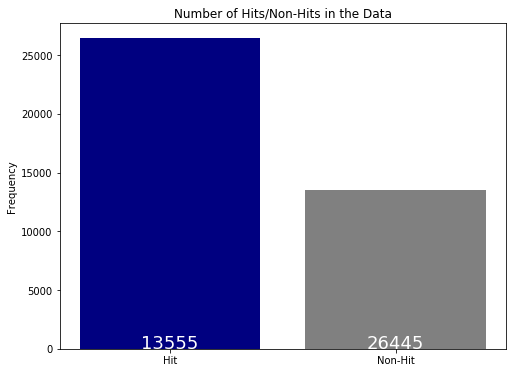

In [11]:
# Visualize the difference between the averages of the control and the mean

plt.figure(figsize=(8,6))
X = ['Hit', 'Non-Hit']
y = df['hit'].value_counts()
plt.bar(X,y, color=('navy','grey'))
plt.text(s=round(y[1],2), x=1, y=10, color="w", horizontalalignment='center',size=18)
plt.text(s=round(y[0],2), x=0, y=10, color="w", horizontalalignment='center',size=18)
plt.ylabel('Frequency')
plt.title('Number of Hits/Non-Hits in the Data')

# STEP 2a. Questions

Of all the players in the dataset:

- Who has the most hits?
- Who hit the ball the hardest?
- What is the distribution of hits?

In [12]:
# Function to visualize and compare two distributions

def visualization(hits, non_hits):
    plt.figure(figsize=[10,6])
    sns.distplot(hits, color='blue', label='Hits', bins = 50)
    plt.axvline(hits.mean(), color='darkblue', label='Hits Mean')
    sns.distplot(non_hits, color='green', label='Non_hits', bins = 50)
    plt.axvline(non_hits.mean(), color='darkgreen', label='Non_hits Mean')
    plt.legend()
    plt.title('Hits vs. Non_hits Launch Angle')
    plt.xlabel('Distribution')
    plt.ylabel('Frequency')
    plt.show()

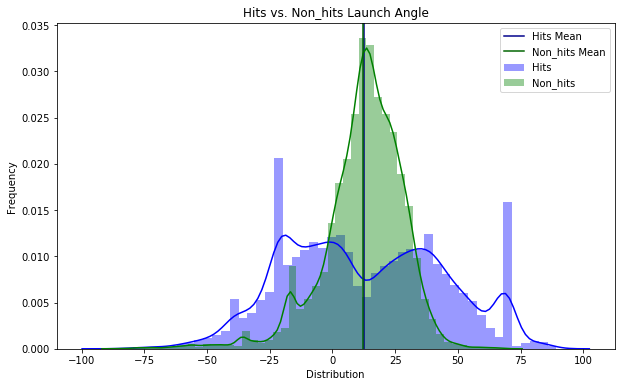

In [13]:
visualization(df.loc[df['hit']==1]['launch_angle'], df.loc[df['hit']==0]['launch_angle'])

In [72]:
df

,game_date,pitcher,pitch_type,p_throws,release_speed,batter,stand,launch_speed,launch_angle,game_pk,hit
0,58,607188,SL,R,83.8,602074,R,40.0,-36.0,565493,0
1,58,543766,FC,R,94.6,621438,R,77.8,-37.3,565493,1
2,58,543766,FC,R,92.9,592325,L,80.6,35.5,565493,1
3,58,519076,SI,R,93.8,641658,R,106.6,14.2,565493,1
4,58,519076,FF,R,94.0,460077,R,86.9,44.3,565493,1
...,...,...,...,...,...,...,...,...,...,...,...
39995,0,501925,CH,R,78.7,605480,L,71.9,47.7,565659,1
39996,0,453284,FS,R,78.9,641477,R,61.2,64.9,567116,1
39997,0,501925,SI,R,86.9,542979,R,104.8,0.1,565659,1
39998,0,665093,FS,R,82.2,488726,L,97.4,-1.4,565659,1


In [81]:
df.dtypes

game_date          int64
pitcher            int64
pitch_type         int64
p_throws           int64
release_speed    float64
batter             int64
stand              int64
launch_speed     float64
launch_angle     float64
game_pk            int64
hit                int64
dtype: object

In [80]:
le = preprocessing.LabelEncoder()
df[['game_date']] = df[['game_date']].apply(le.fit_transform)
df[['pitch_type']] = df[['pitch_type']].apply(le.fit_transform)
df[['p_throws']] = df[['p_throws']].apply(le.fit_transform)
df[['pitch_type']] = df[['pitch_type']].apply(le.fit_transform)
df[['stand']] = df[['stand']].apply(le.fit_transform)

In [82]:
df = df.dropna()

# Subsetting target variable
target = df['hit']

# Preparing features
features = df.drop(['hit'], axis = 1, inplace = False)


In [83]:
df.isna().sum()

game_date        0
pitcher          0
pitch_type       0
p_throws         0
release_speed    0
batter           0
stand            0
launch_speed     0
launch_angle     0
game_pk          0
hit              0
dtype: int64

In [84]:
features.shape

(39816, 10)

In [85]:
X_test = features.tail(3000)
y_test = target.tail(3000)

X_train = features.head(37000)
y_train = target.head(37000)

In [86]:
# Testing/Trainging data split for model 

#X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20)

In [89]:
### Model 1 - Decision Tree
dt = DecisionTreeClassifier(random_state=10)  

# train
dt = dt.fit(X_train, y_train)

# predict
dt_train_preds = dt.predict(X_train)
dt_test_preds = dt.predict(X_test)

# evaluate
dt_train_accuracy = accuracy_score(y_train, dt_train_preds)
dt_test_accuracy = accuracy_score(y_test, dt_test_preds)

# -------------------------------------------------------------

### Model 2 - Random Forest
rfc = RandomForestClassifier()

# train
rfc = rfc.fit(X_train, y_train)

# predict
rfc_train_preds = rfc.predict(X_train)
rfc_test_preds = rfc.predict(X_test)

# evaluate
rfc_train_accuracy = accuracy_score(y_train, rfc_train_preds)
rfc_test_accuracy = accuracy_score(y_test, rfc_test_preds)

# -------------------------------------------------------------

### Model 3 - Adaboost
adaboost = AdaBoostClassifier()

# train
adaboost = adaboost.fit(X_train, y_train)

# predict
adaboost_train_preds = adaboost.predict(X_train)
adaboost_test_preds = adaboost.predict(X_test)

# evaluate
adaboost_train_accuracy = accuracy_score(y_train, adaboost_train_preds)
adaboost_test_accuracy = accuracy_score(y_test, adaboost_test_preds)

# -------------------------------------------------------------
print('Vanilla Decision Tree')
print('------------------------------------------------------')
print(f"Training Accuracy: {(dt_train_accuracy * 100):.4}%")
print(f"Test Accuracy:     {(dt_test_accuracy * 100):.4}%")
print('\n')
print('------------------------------------------------------')
print('\n')
print('Random Forest')
print('------------------------------------------------------')
print(f"Training Accuracy: {(rfc_train_accuracy * 100):.4}%")
print(f"Test Accuracy:     {(rfc_test_accuracy * 100):.4}%")
print('\n')
print('------------------------------------------------------')
print('\n')
print('Adaboost')
print('------------------------------------------------------')
print(f"Training Accuracy: {(adaboost_train_accuracy * 100):.4}%")
print(f"Test Accuracy:     {(adaboost_test_accuracy * 100):.4}%")


/Users/Kelly/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Vanilla Decision Tree
------------------------------------------------------
Training Accuracy: 100.0%
Test Accuracy:     72.93%


------------------------------------------------------


Random Forest
------------------------------------------------------
Training Accuracy: 99.09%
Test Accuracy:     77.37%


------------------------------------------------------


Adaboost
------------------------------------------------------
Training Accuracy: 77.95%
Test Accuracy:     76.8%


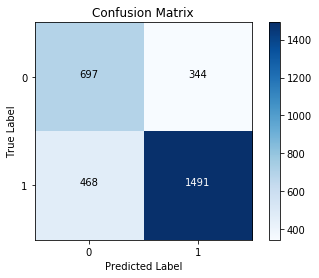

In [95]:
show_cf(y_test, dt_test_preds)

In [96]:
feat_importance = dt.tree_.compute_feature_importances(normalize=False)
print("feat importance = " + str(feat_importance))

feat importance = [0.02937069 0.0349246  0.01204461 0.00381299 0.03528218 0.03554008
 0.00482471 0.12720957 0.12714142 0.03769338]


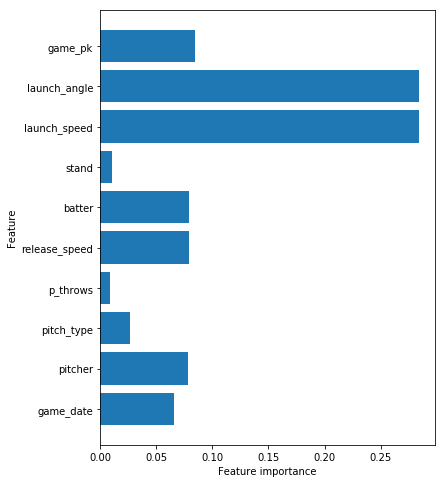

In [98]:
plot_feature_importances(dt)

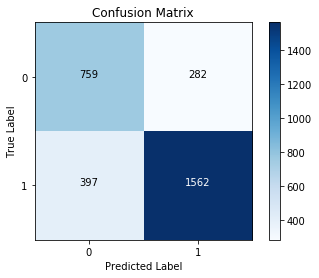

In [99]:
show_cf(y_test, rfc_test_preds)

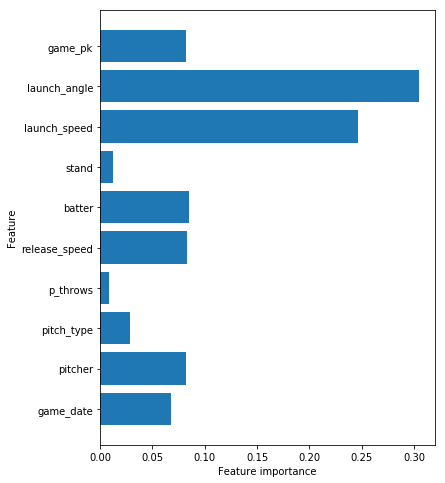

In [100]:
plot_feature_importances(rfc)

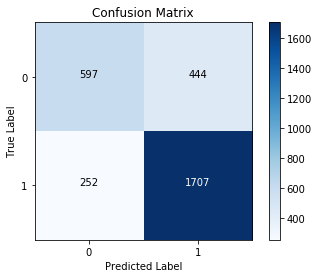

In [102]:
show_cf(y_test, adaboost_test_preds)

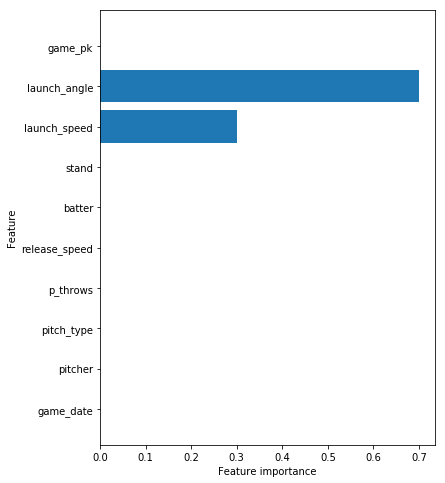

In [103]:
plot_feature_importances(adaboost)

In [106]:
X_test['preds'] = adaboost_test_preds

/Users/Kelly/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [108]:
X_test['hit'] = y_test

/Users/Kelly/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [110]:
check = X_test.loc[X_test['game_date']==4]

In [115]:
check = check.loc[(check['hit']==1)&(check['preds']==1)]
check.loc[check['batter']==605612]

,game_date,pitcher,pitch_type,p_throws,release_speed,batter,stand,launch_speed,launch_angle,game_pk,preds,hit
37017,4,607481,8,0,94.0,605612,0,71.0,-38.6,565520,1,1
37103,4,592229,0,1,85.5,605612,0,82.9,-20.7,565562,1,1
37273,4,656302,0,1,85.1,605612,0,80.0,33.5,565520,1,1
37304,4,502327,9,0,84.7,605612,0,78.9,34.1,565562,1,1
37403,4,656302,4,1,96.9,605612,0,77.5,25.8,565520,1,1
37478,4,502327,9,0,85.3,605612,0,93.4,43.5,565562,1,1


In [113]:
check['batter'].value_counts()

605612    7
547989    6
608475    6
544725    6
641553    5
         ..
445988    1
501981    1
572761    1
641487    1
641598    1
Name: batter, Length: 264, dtype: int64